In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.cm as cm

In [2]:
# Load the dataset
file_path = r"C:\Users\Andrea\Desktop\thesis\Modified_CSV_Street\BCN_dataset_complete.csv"
df = pd.read_csv(file_path)

# Basic Info
print("Dataset Shape:", df.shape)

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nFirst 5 Rows:")
print(df.head())

print("\nMissing Values Per Column:")
print(df.isna().sum())

print("\nSummary Statistics (numeric only):")
print(df.describe())

Dataset Shape: (14831, 34)

Column Names:
['FID', 'COORD_X', 'COORD_Y', 'LONGITUD', 'ANGLE', 'C_Tram', 'C_Nus_I', 'C_Nus_F', 'Distric_D', 'NDistric_D', 'Illa_D', 'CVia_D', 'TVia_D', 'NVia_D', 'Tram_Dret', 'Distric_E', 'NDistric_E', 'Illa_E', 'CVia_E', 'TVia_E', 'NVia_E', 'Tram_Esq', 'BuildingHeight_Right', 'BuildingHeight_Left', 'BuildingHeight_Mean', 'Street_Buffer', 'Number_of_Trees', 'Mean_Tree_Height', 'Mean_Tree_Circumfere', 'Total_Canopy_Area_m2', 'ANGLE_rad', 'ANGLE_sin', 'ANGLE_cos', 'Tmrt_Buildings_Mean']

Data Types:
FID                       int64
COORD_X                 float64
COORD_Y                 float64
LONGITUD                float64
ANGLE                   float64
C_Tram                   object
C_Nus_I                  object
C_Nus_F                  object
Distric_D                 int64
NDistric_D               object
Illa_D                    int64
CVia_D                    int64
TVia_D                   object
NVia_D                   object
Tram_Dret          

In [3]:
# Drop rows where target is missing
df = df.dropna(subset=['Tmrt_Buildings_Mean'])

In [4]:
# --- Feature engineering ---
df['Aspect_Ratio'] = df['BuildingHeight_Mean'] / df['Street_Buffer']
df['Height_Diff'] = (df['BuildingHeight_Right'] - df['BuildingHeight_Left']).abs()
df['Tree_Density'] = df['Number_of_Trees'] / df['Street_Buffer']
df['Relative_Canopy'] = df['Total_Canopy_Area_m2'] / df['Street_Buffer']
df['Tree_Height_Ratio'] = df['Mean_Tree_Height'] / (df['BuildingHeight_Mean'] + 1e-6)

# Optional: orientation interactions
#df['StreetBuffer_cos'] = df['Street_Buffer'] * df['ANGLE_cos']
#df['StreetBuffer_sin'] = df['Street_Buffer'] * df['ANGLE_sin']


In [17]:
# Select relevant numeric features
selected_features = [    
    'BuildingHeight_Mean',
    'Street_Buffer',
    'Number_of_Trees',
    'Mean_Tree_Height',
    'Total_Canopy_Area_m2',
    'ANGLE_sin',
    'ANGLE_cos',
    'ANGLE_rad',
    #'BuildingHeight_Right',
    #'BuildingHeight_Left',
    'Aspect_Ratio',
    'Height_Diff',
    'Tree_Density',
    'Relative_Canopy',
    'Tree_Height_Ratio',
    #'StreetBuffer_cos',
    #'StreetBuffer_sin',
    'Tmrt_Buildings_Mean'
]

# Keep only selected numeric columns
df_selected = df[selected_features]

# Ensure all values are numeric and drop any remaining NaNs
df_selected = df_selected.apply(pd.to_numeric, errors='coerce').dropna()

print("Cleaned dataset shape:", df_selected.shape)
print("\nColumns:", df_selected.columns.tolist())
print("\nFirst 5 rows:")
print(df_selected.head())

Cleaned dataset shape: (2000, 14)

Columns: ['BuildingHeight_Mean', 'Street_Buffer', 'Number_of_Trees', 'Mean_Tree_Height', 'Total_Canopy_Area_m2', 'ANGLE_sin', 'ANGLE_cos', 'ANGLE_rad', 'Aspect_Ratio', 'Height_Diff', 'Tree_Density', 'Relative_Canopy', 'Tree_Height_Ratio', 'Tmrt_Buildings_Mean']

First 5 rows:
    BuildingHeight_Mean  Street_Buffer  Number_of_Trees  Mean_Tree_Height  \
3                  18.0          10.00                0              0.00   
8                  22.0          18.00                4             13.75   
14                 22.4          22.96                2             10.00   
15                 25.9          10.00                2             10.00   
19                 17.6          10.00                0              0.00   

    Total_Canopy_Area_m2  ANGLE_sin  ANGLE_cos  ANGLE_rad  Aspect_Ratio  \
3                   0.00   0.190466   0.981694   0.191637      1.800000   
8                  50.27   0.284015   0.958820   0.287979      1.222222   


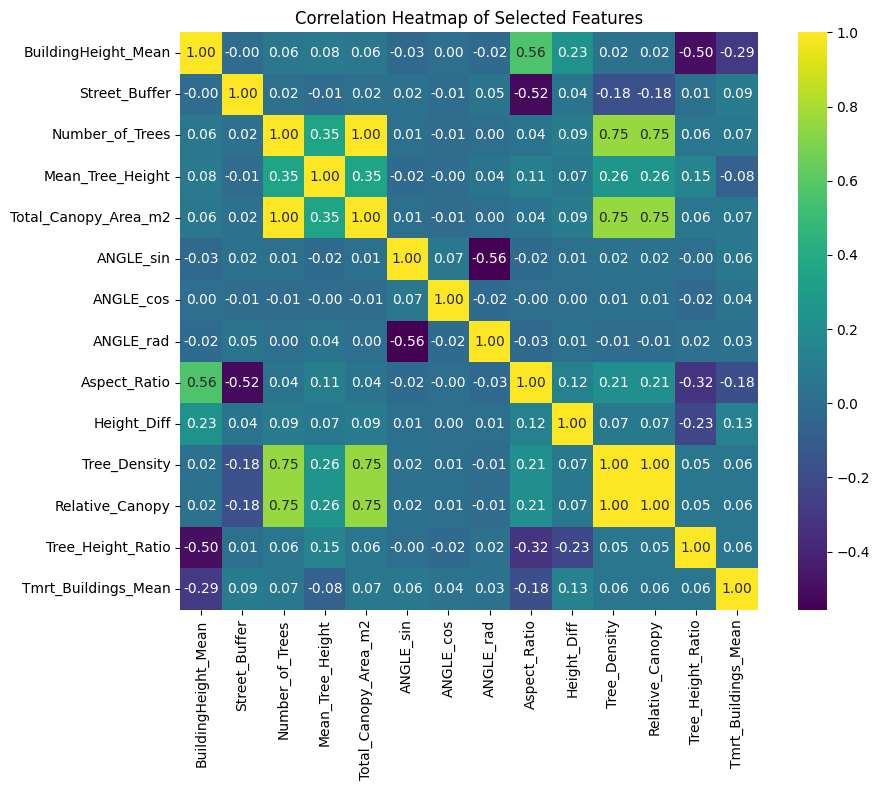

In [18]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_selected.corr(), annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()

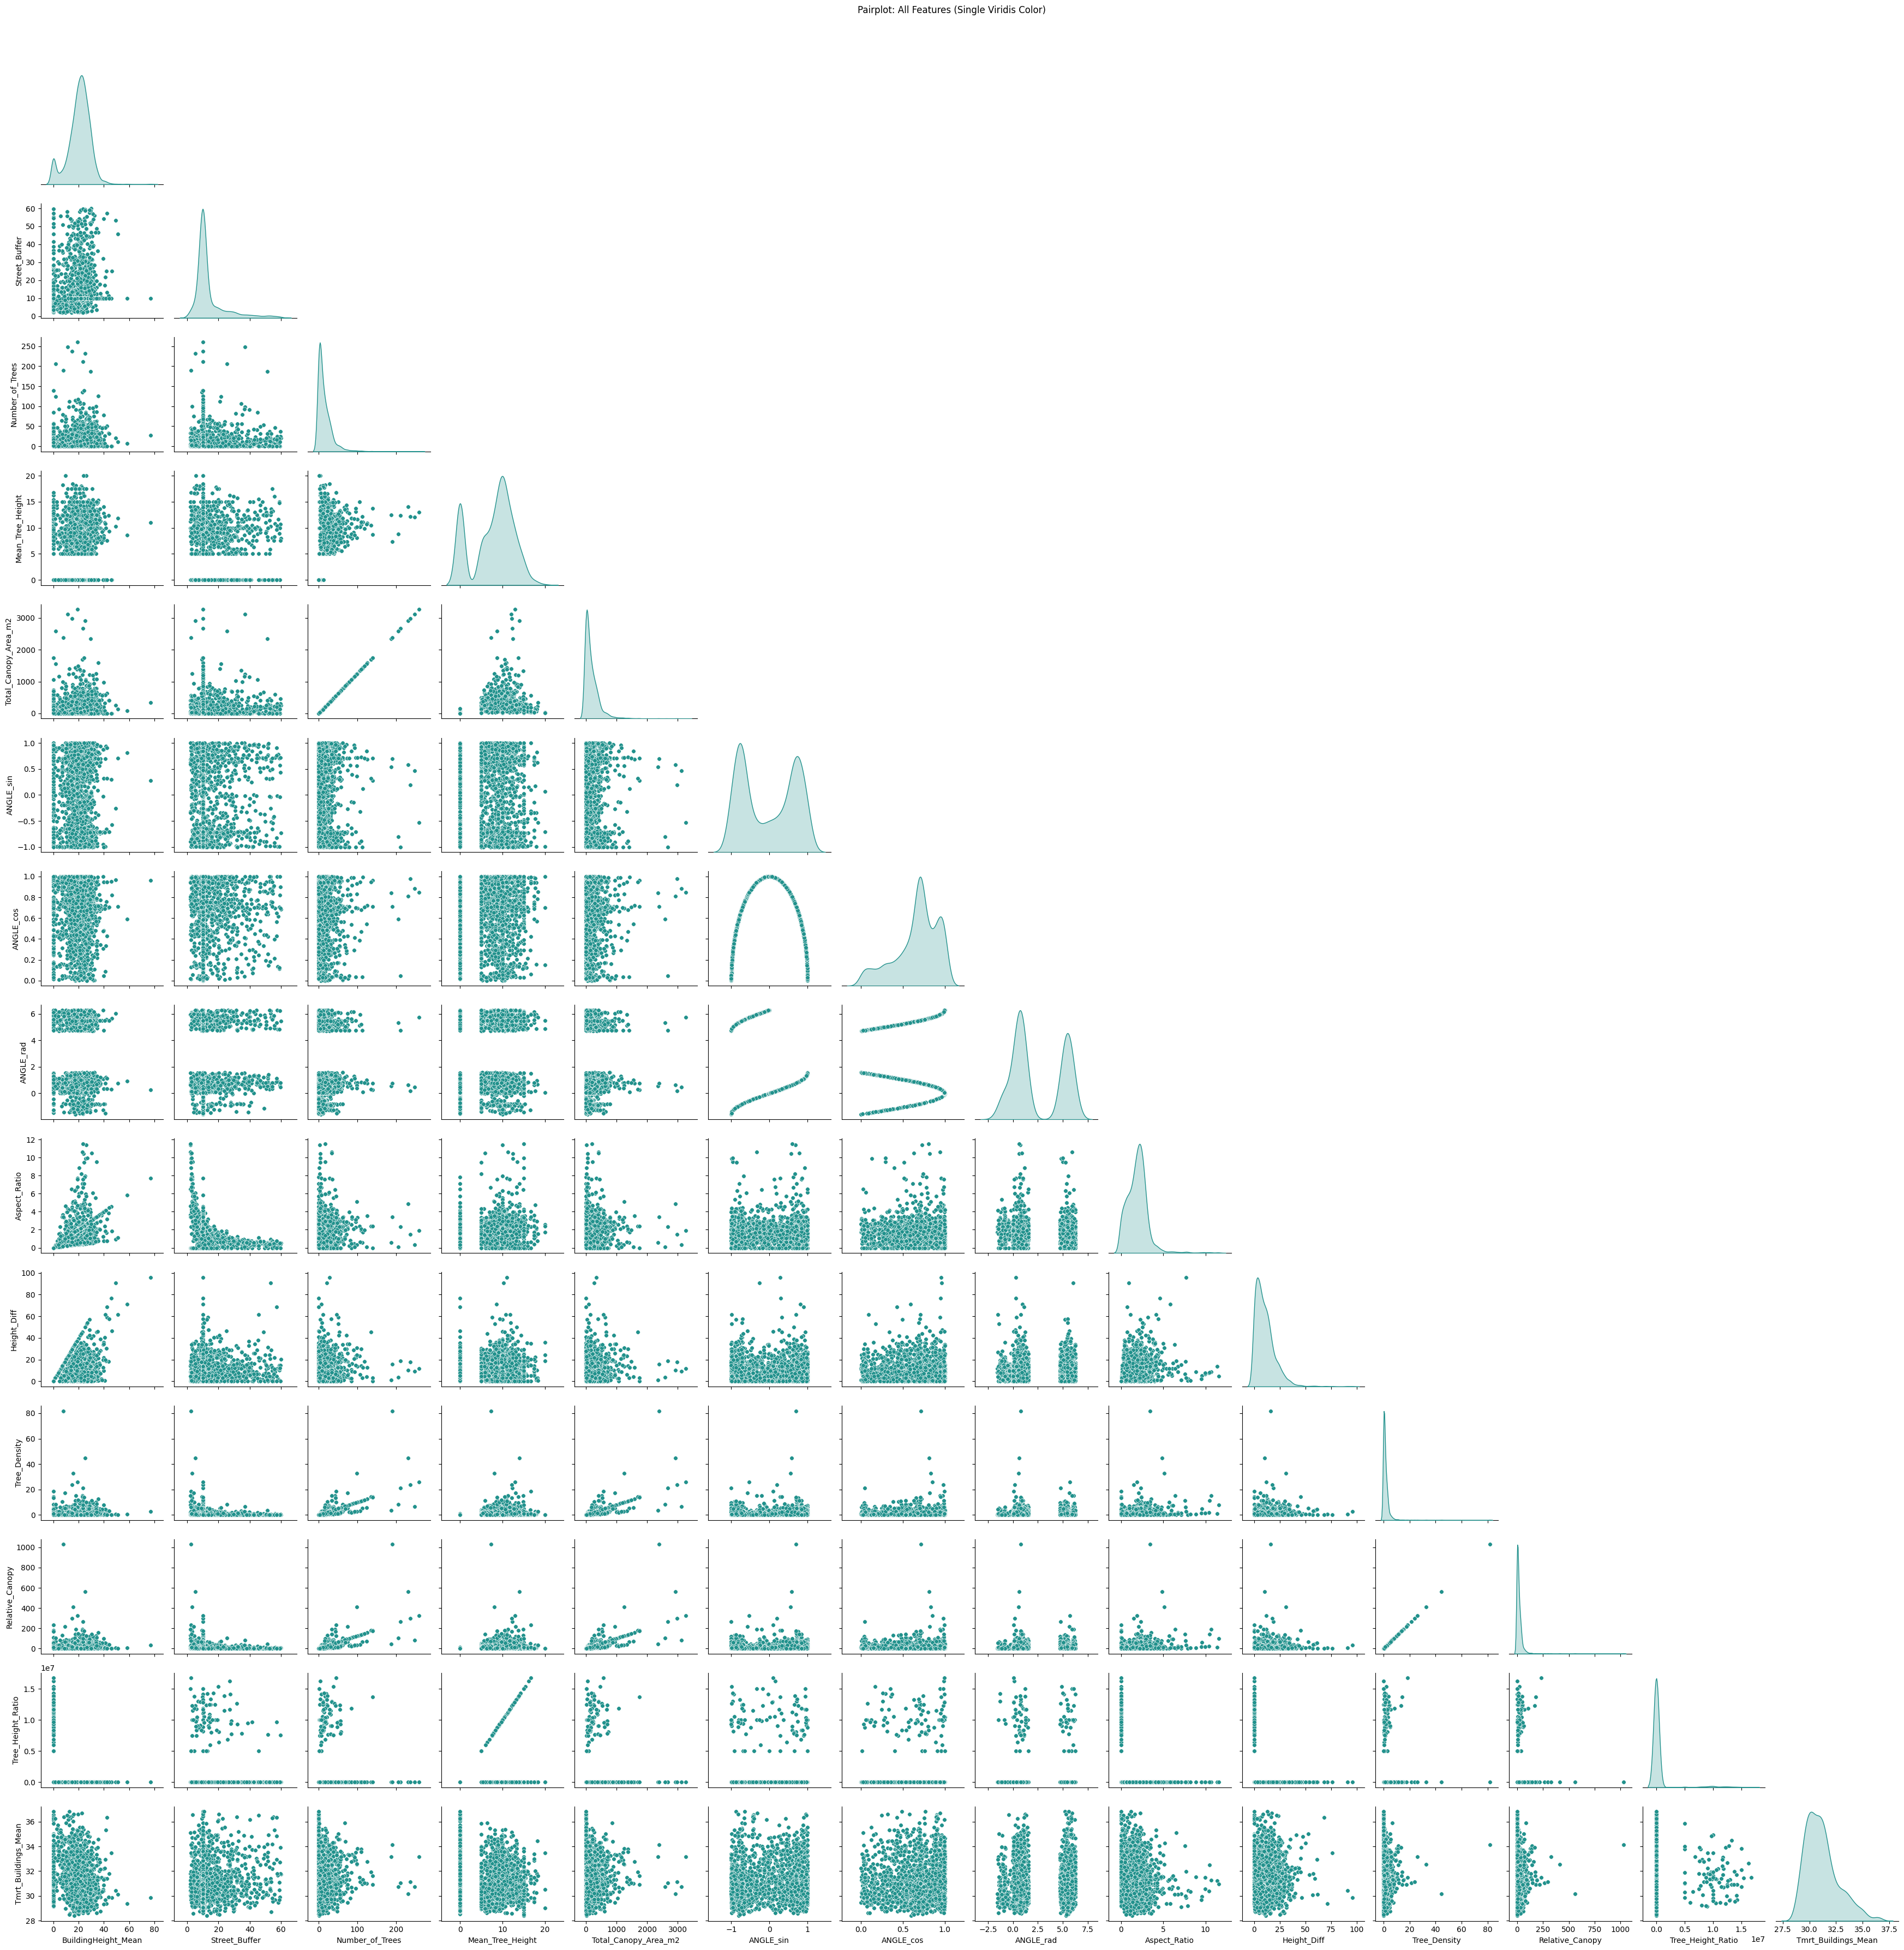

In [19]:
# Pick a single Viridis color (mid-point of the colormap)
viridis_color = plt.colormaps["viridis"](0.5)

# Build pairplot with same Viridis color for scatter + KDE
g = sns.pairplot(
    df_selected,
    diag_kind='kde',
    corner=True,
    plot_kws={'s': 30, 'edgecolor': 'white', 'color': viridis_color},
    diag_kws={'color': viridis_color}
)

plt.suptitle("Pairplot: All Features (Single Viridis Color)", y=1.02)
plt.tight_layout()
plt.show()


Top 4 correlated features: ['BuildingHeight_Mean', 'Aspect_Ratio', 'Height_Diff', 'Street_Buffer']


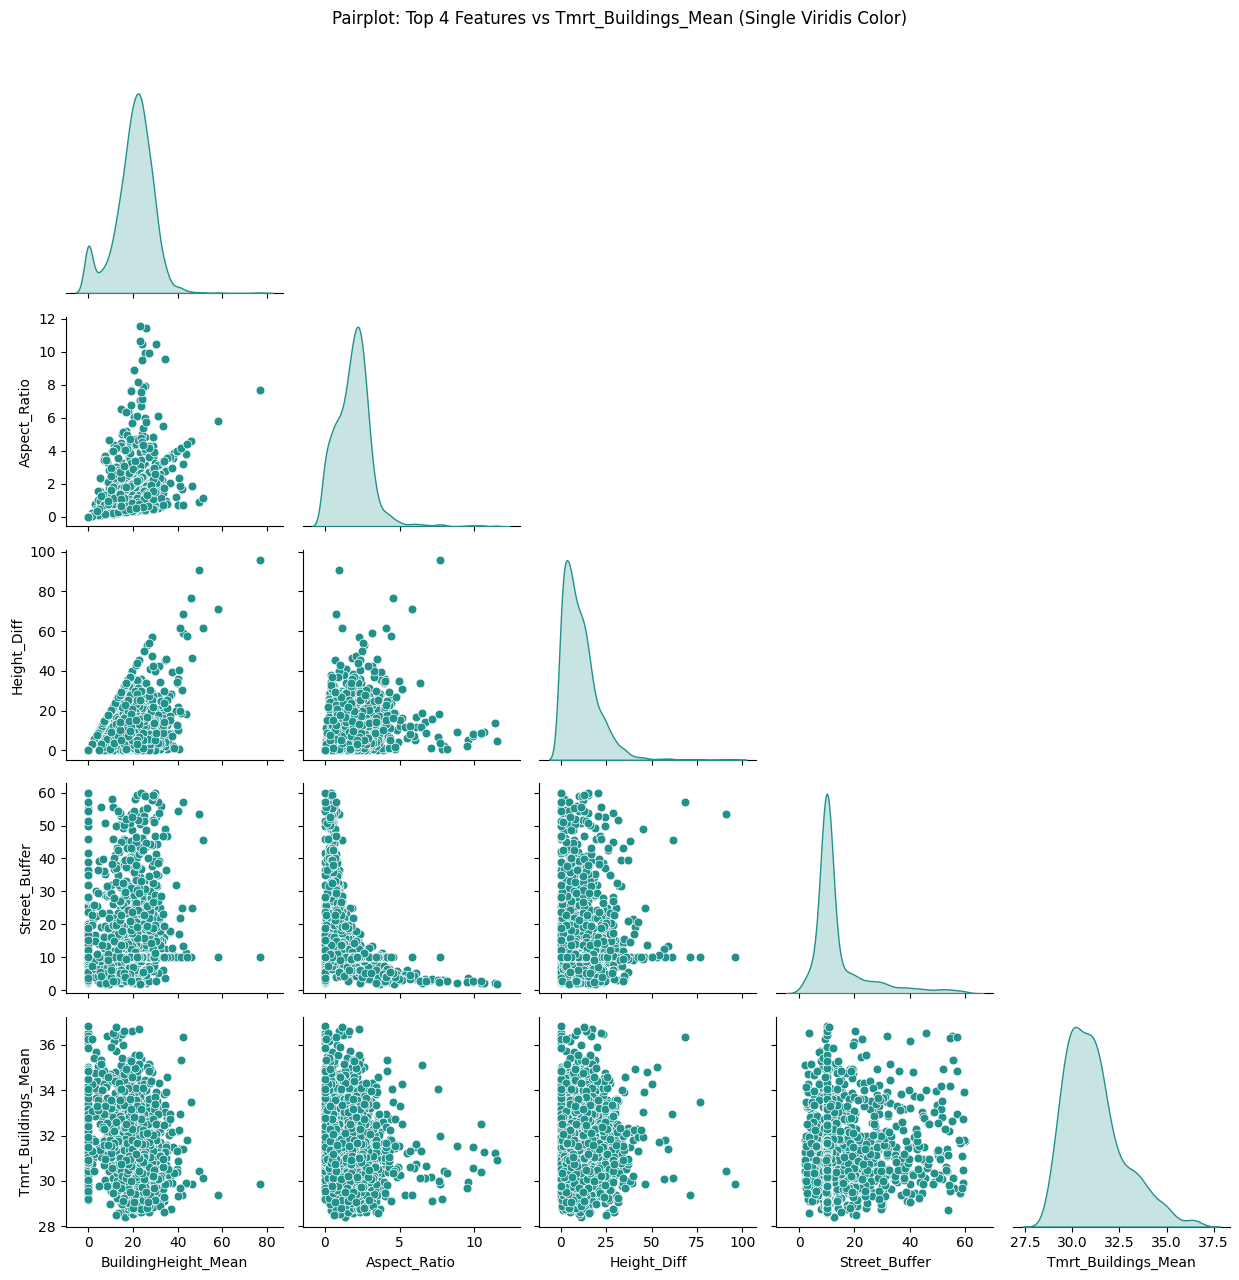

In [20]:
# --- Find top 4 correlated features ---
corr = df_selected.corr()
top_corr = corr['Tmrt_Buildings_Mean'].drop('Tmrt_Buildings_Mean').abs()
top_4_features = top_corr.sort_values(ascending=False).head(4).index.tolist()
print("\nTop 4 correlated features:", top_4_features)

# --- Create dataframe with only top 4 + target ---
df_top4 = df_selected[top_4_features + ['Tmrt_Buildings_Mean']]

# Pick a single Viridis color (0.0 = yellow, 1.0 = dark purple, 0.5 = mid green/blue)
viridis_color = plt.colormaps["viridis"](0.5)

# --- Pairplot ---
g = sns.pairplot(
    df_top4,   # or df_selected if you want all features
    diag_kind='kde',
    corner=True,
    plot_kws={'s': 40, 'edgecolor': 'white', 'color': viridis_color},
    diag_kws={'color': viridis_color}
)

plt.suptitle("Pairplot: Top 4 Features vs Tmrt_Buildings_Mean (Single Viridis Color)", y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# --- Normalize Features ---
X = df_selected.drop(columns='Tmrt_Buildings_Mean')
y = df_selected['Tmrt_Buildings_Mean']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['Tmrt_Buildings_Mean'] = y.values  # Optionally keep target

# --- Preview Normalized Data ---
print("\nNormalized Features Preview:")
print(X_scaled_df.head())


Normalized Features Preview:
   BuildingHeight_Mean  Street_Buffer  Number_of_Trees  Mean_Tree_Height  \
0            -0.269457      -0.398354        -0.669326         -1.603034   
1             0.196550       0.381527        -0.490815          1.242291   
2             0.243151       0.865053        -0.580070          0.466293   
3             0.650907      -0.398354        -0.580070          0.466293   
4            -0.316057      -0.398354        -0.669326         -1.603034   

   Total_Canopy_Area_m2  ANGLE_sin  ANGLE_cos  ANGLE_rad  Aspect_Ratio  \
0             -0.669326   0.305394   1.252009  -0.903004     -0.095680   
1             -0.490799   0.438341   1.162176  -0.864977     -0.551007   
2             -0.580080   0.424050   1.173650  -0.869111     -0.745354   
3             -0.580080   0.419277   1.177382  -0.870488      0.526893   
4             -0.669326   0.431201   1.167964  -0.867044     -0.127202   

   Height_Diff  Tree_Density  Relative_Canopy  Tree_Height_Ratio  \


Regression model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- Prepare data ---
X = X_scaled_df.drop(columns='Tmrt_Buildings_Mean')
y = X_scaled_df['Tmrt_Buildings_Mean']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predict ---
y_pred = model.predict(X_test)

# --- Evaluate ---
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n MAE: {mae:.2f}")
print(f" R² Score: {r2:.2f}")



 MAE: 1.07
 R² Score: 0.11


Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")


Random Forest MAE: 1.00
Random Forest R²: 0.17


C:\Users\Andrea\AppData\Local\Temp\ipykernel_15396\50622065.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


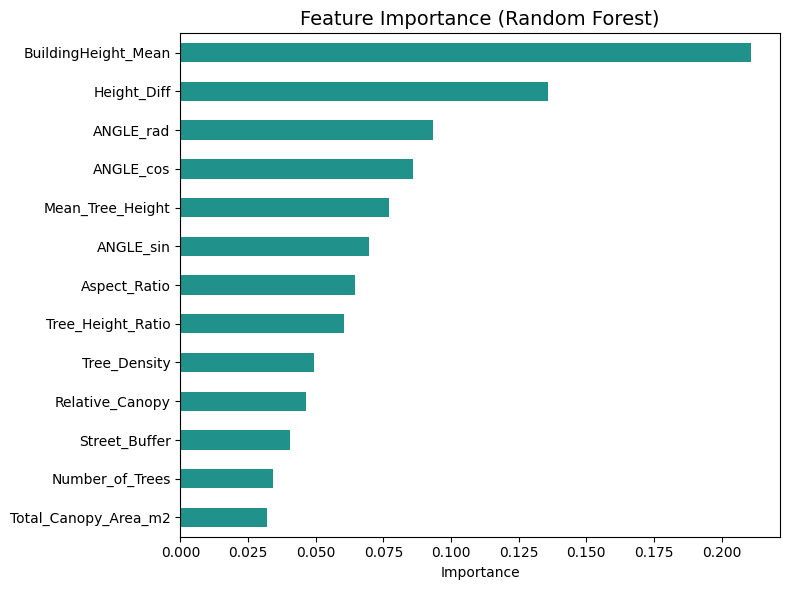

In [24]:
# --- Compute importances ---
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()

# --- Choose a single Viridis color (e.g., middle of the colormap) ---
viridis = cm.get_cmap('viridis')
single_color = viridis(0.5)  # 0 = light, 1 = dark — 0.5 = middle

# --- Plot ---
plt.figure(figsize=(8, 6))
importances_sorted.plot(kind='barh', color=single_color)
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


XGBoost

XGBoost MAE: 0.99
XGBoost R²: 0.20


<Figure size 600x600 with 0 Axes>

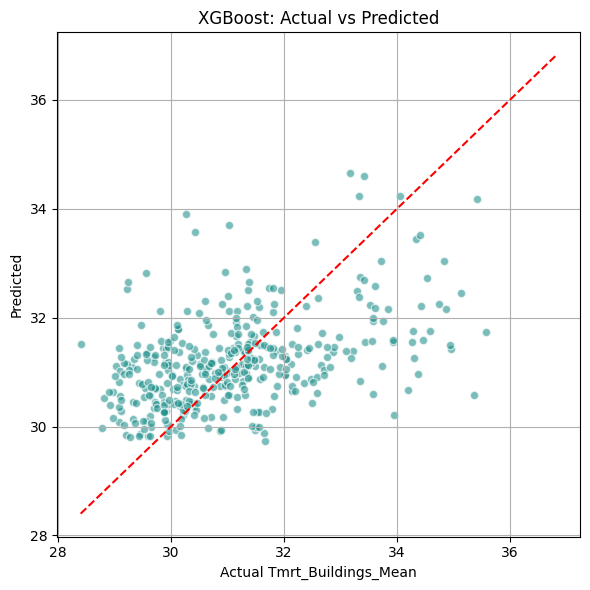

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

df = df[selected_features].apply(pd.to_numeric, errors='coerce').dropna()

# --- Features and target ---
X = df.drop(columns='Tmrt_Buildings_Mean')
y = df['Tmrt_Buildings_Mean']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train XGBoost Regressor ---
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = xgb_model.predict(X_test)

# --- Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost R²: {r2:.2f}")

plt.figure(figsize=(6, 6))

viridis_color = plt.colormaps["viridis"](0.5)

plt.figure(figsize=(6, 6))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.6,
    color=viridis_color,
    edgecolor="white"
)

# 1:1 reference line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')

# Labels and title
plt.xlabel("Actual Tmrt_Buildings_Mean")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

plt.grid(True)
plt.tight_layout()
plt.show()

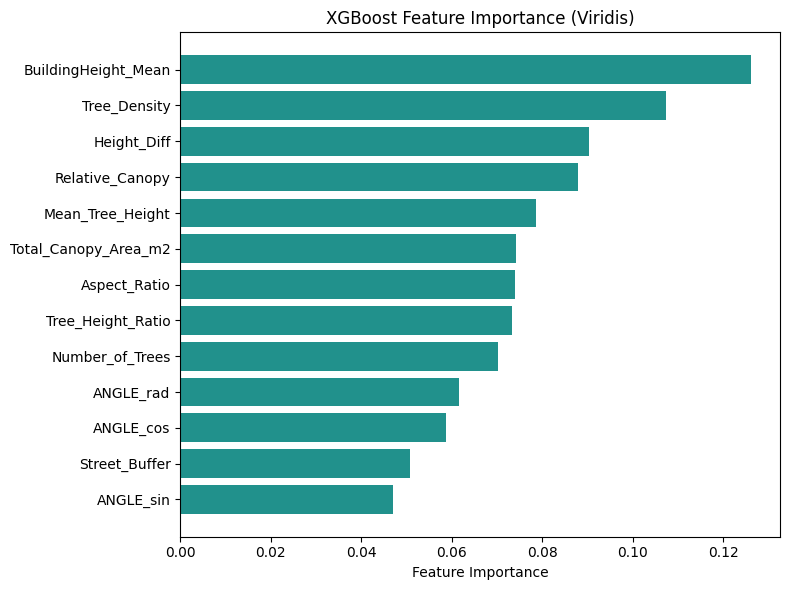

In [30]:
importances = xgb_model.feature_importances_
feature_names = X.columns

# Sort by importance
sorted_idx = np.argsort(importances)

# Pick a single Viridis color
viridis_color = plt.colormaps["viridis"](0.5)

plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[sorted_idx], color=viridis_color)
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (Viridis)")
plt.tight_layout()
plt.show()


In [31]:
import joblib

# Save model
model_path = r"C:\Users\Andrea\Desktop\trainedmodels\xgboost_tmrt_model_test.joblib"
joblib.dump(xgb_model, model_path)
print(f"✅ Model saved to: {model_path}")



✅ Model saved to: C:\Users\Andrea\Desktop\trainedmodels\xgboost_tmrt_model_test.joblib


In [32]:
import pandas as pd
import numpy as np
import joblib

# --- Load trained model ---
model_path = r"C:\Users\Andrea\Desktop\trainedmodels\xgboost_tmrt_model_test.joblib"
model = joblib.load(model_path)

# --- Load new data ---
new_data_path = r"C:\Users\Andrea\Desktop\thesis\Modified_CSV_Street\BCN_GrafVial_With_Orientation.csv"
df = pd.read_csv(new_data_path)

df['Aspect_Ratio'] = df['BuildingHeight_Mean'] / df['Street_Buffer']
df['Height_Diff'] = (df['BuildingHeight_Right'] - df['BuildingHeight_Left']).abs()
df['Tree_Density'] = df['Number_of_Trees'] / df['Street_Buffer']
df['Relative_Canopy'] = df['Total_Canopy_Area_m2'] / df['Street_Buffer']
df['Tree_Height_Ratio'] = df['Mean_Tree_Height'] / (df['BuildingHeight_Mean'] + 1e-6)

feature_cols = [
    'BuildingHeight_Mean',
    'Street_Buffer',
    'Number_of_Trees',
    'Mean_Tree_Height',
    'Total_Canopy_Area_m2',
    'ANGLE_sin',
    'ANGLE_cos',
    'ANGLE_rad',
    #'BuildingHeight_Right',
    #'BuildingHeight_Left',
    'Aspect_Ratio',
    'Height_Diff',
    'Tree_Density',
    'Relative_Canopy',
    'Tree_Height_Ratio',
    #'StreetBuffer_cos',
    #'StreetBuffer_sin',
]

# Keep original for re-attaching results
df_clean = df.copy()
df_clean = df_clean[feature_cols].apply(pd.to_numeric, errors='coerce')
mask = df_clean.dropna().index

# --- Predict only where data is clean ---
df.loc[mask, 'Predicted_Tmrt_Buildings_Mean'] = model.predict(df_clean.loc[mask])

# --- Save result ---
output_path = r"C:\Users\Andrea\Desktop\thesis\Modified_CSV_Street\BCN_GrafVial_Predicted_new.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"✅ Predictions saved to: {output_path}")


✅ Predictions saved to: C:\Users\Andrea\Desktop\thesis\Modified_CSV_Street\BCN_GrafVial_Predicted_new.csv
